# gurobiによる制約最適化を行う

In [2]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx
from gurobipy import *

## 変数
- $x_{ik}$ $x_{jl}$ : 人iが避難施設kに避難した場合に１　バイナリー変数

## 定数

- $D_{kl}$ : 避難施設kとlの間に定義される伝染危険率
    - 二つの距離が近いと大きい

- $W_{ij} $ : 人i,jでの伝染危険率(以下の二つの重み付き自乗和)

    - 感染の差の自乗とmax(jの感染率 – iの感染率,0)・iの死亡率 + max(iの感染率 – jの感染率,0)・ jの死亡率
    - 感染率の差の自乗和
- $H_{ik} $ : 人iが避難施設kに避難した時の死亡率
## 目的関数
-  min $\sum_{ijkl}^{} W_{ij} D_{kl}  x_{ik}  x_{jl}$


## 制約
- すべての人 iに対して，x[i,k]の施設kに対する合計 = 1   

- 施設kに対してx[i]=kの人に対する合計が施設kの容量以下

## 必要な集合
- 人の集合 people
- 人の感染率の集合 infec_rate
- 人の死亡率の集合 mort_rate
- 施設集合 shelters
- 施設の位置情報 locations
- 施設の容量 capacity

In [4]:
random.seed(2)

In [5]:
N = 10 #人の数
people = [i for i in range(N)] #人の集合
infec_rate,mort_rate = {},{}
for i in people:
    infec_rate[i] = random.randint(0,100)/100
    mort_rate[i] = random.randint(0,100)/100
print(infec_rate)
print(mort_rate)

{0: 0.07, 1: 0.1, 2: 0.21, 3: 0.85, 4: 0.32, 5: 0.27, 6: 0.04, 7: 0.87, 8: 0.55, 9: 0.5}
{0: 0.11, 1: 0.46, 2: 0.94, 3: 0.39, 4: 0.77, 5: 0.77, 6: 0.74, 7: 0.2, 8: 0.81, 9: 0.92}


In [6]:
N_s = 5
shelters = [i for i in range(N_s)] #施設の集合
capacity = {}
for i in shelters:
    capacity[i] = random.randint(1,3)
locations= np.random.rand(N_s, 2) * 100
print(locations)
print(capacity)

[[25.93877229 85.91834048]
 [73.87067113 67.38237736]
 [10.09168631 35.47285206]
 [82.56191533 36.64057423]
 [88.20547668 52.08867554]]
{0: 3, 1: 2, 2: 3, 3: 2, 4: 3}


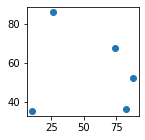

In [7]:
plt.figure(figsize=(2, 2))
plt.plot(locations[:, 0], locations[:, 1], 'o')
plt.show()

In [8]:
#D[k,l]施設間の感染率　簡易的に距離で置いている 反比例
x_y = np.array(locations)
x = x_y[:, 0]
y = x_y[:, 1]
#D = np.sqrt((x[:, np.newaxis] - x[np.newaxis, :]) ** 2 +(y[:, np.newaxis] - y[np.newaxis, :]) ** 2)

In [9]:
D = np.zeros((N_s,N_s))
for i in shelters:
    for j in shelters:
        if i == j:
            D[i,j] = 1
D

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [10]:
#W[i,j]
W = np.zeros((N,N))
for i in people:
    for j in people:
        w1 = max(infec_rate[j] - infec_rate[i],0) * mort_rate[i] + max(infec_rate[i] - infec_rate[j],0) * mort_rate[j]
        w2 = (infec_rate[j] - infec_rate[i]) ** 2
        W[i,j] = w1*w2
W

array([[0.0000000e+00, 2.9700000e-06, 3.0184000e-04, 5.2200720e-02,
        1.7187500e-03, 8.8000000e-04, 1.9980000e-05, 5.6320000e-02,
        1.2165120e-02, 8.7457700e-03],
       [2.9700000e-06, 0.0000000e+00, 6.1226000e-04, 1.9406250e-01,
        4.8980800e-03, 2.2599800e-03, 1.5984000e-04, 2.1000518e-01,
        4.1917500e-02, 2.9440000e-02],
       [3.0184000e-04, 6.1226000e-04, 0.0000000e+00, 2.4641536e-01,
        1.2511400e-03, 2.0304000e-04, 3.6356200e-03, 2.7024624e-01,
        3.6945760e-02, 2.2925660e-02],
       [5.2200720e-02, 1.9406250e-01, 2.4641536e-01, 0.0000000e+00,
        1.1463529e-01, 1.5023624e-01, 3.9326634e-01, 3.1200000e-06,
        2.1870000e-02, 3.9445000e-02],
       [1.7187500e-03, 4.8980800e-03, 1.2511400e-03, 1.1463529e-01,
        0.0000000e+00, 9.6250000e-05, 1.6244480e-02, 1.2810875e-01,
        9.3685900e-03, 4.4906400e-03],
       [8.8000000e-04, 2.2599800e-03, 2.0304000e-04, 1.5023624e-01,
        9.6250000e-05, 0.0000000e+00, 9.0035800e-03, 1.66

In [11]:
model = Model()

Using license file /Users/suzukinatsuki/gurobi.lic
Academic license - for non-commercial use only


In [12]:
#人iが避難施設kに避難した場合に1になる0-1変数 x[i,k] x[j,l]
x = {}
for i in people:
    for k in shelters:
        x[i,k] = model.addVar(ub=1, vtype="B", name="x(%s,%s)"%(i,k))
        
#for j in people:
#    for l in shelters:
#        x[j,l] = model.addVar(ub=1, vtype="B", name="x(%s,%s)"%(j,l))
        
model.update()

In [13]:
# z[i,k,j,l]という新しい変数をおく
z = {}
for i in people:
    for k in shelters:
        for j in people:
            for l in shelters:
                if j != i: 
                    z[i,k,j,l] = model.addVar(vtype="B",name="z(%s,%s,%s,%s)"%(i,k,j,l))
model.update()

## 制約

In [14]:
# すべての人 iに対して，x[i,k]の施設kに対する合計 = 1   
for i in people:
    model.addConstr(quicksum(x[i,k] for k in shelters)== 1)
    
#すべての施設kに対して，x[i,k] の人に対する合計が施設kの容量以下
for k in shelters:
    model.addConstr(quicksum(x[i,k] for i in people) <= capacity[k])
model.update()

In [15]:
# Z[i,k,j,l]の制約
for i in people:
    for k in shelters:
        for j in people:
            for l in shelters:
                if j != i:
                    model.addConstr(z[i,k,j,l] >= x[i,k] + x[j,l] -1)
model.update()

In [16]:
#目的関数
model.setObjective(quicksum(W[i,j]*D[k,l]*z[i,k,j,l]
                            for i in people
                            for j in people
                            for k in shelters
                            for l in shelters
                            if j!=i), GRB.MINIMIZE)

model.update()

In [17]:
model.params.DualReductions = 0
model.params.LazyConstraints = 1
model.optimize()
#model.Params.Timelimit = 3600

print ("Optimal solution:",model.ObjVal)

Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 2265 rows, 2300 columns and 6850 nonzeros
Model fingerprint: 0x4fdfab99
Variable types: 0 continuous, 2300 integer (2300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 0.4354709
Presolve time: 0.01s
Presolved: 2265 rows, 2300 columns, 6850 nonzeros
Variable types: 0 continuous, 2300 integer (2300 binary)

Root relaxation: objective 0.000000e+00, 73 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   20    0.43547    0.00000   100%   

In [18]:
#変数の確認
for v in model.getVars():
    if v.X> 0:
        print(v.VarName, v.X)

x(0,2) 1.0
x(1,2) 1.0
x(2,3) 1.0
x(3,4) 1.0
x(4,0) 1.0
x(5,0) 1.0
x(6,2) 1.0
x(7,4) 1.0
x(8,1) 1.0
x(9,1) 1.0
z(0,0,1,3) 1.0
z(0,0,8,4) 1.0
z(0,1,1,4) 1.0
z(0,1,2,2) 1.0
z(0,1,3,2) 1.0
z(0,1,3,3) 1.0
z(0,1,3,4) 1.0
z(0,1,4,2) 1.0
z(0,1,4,3) 1.0
z(0,1,5,2) 1.0
z(0,1,5,3) 1.0
z(0,1,5,4) 1.0
z(0,1,6,0) 1.0
z(0,1,6,2) 1.0
z(0,1,7,0) 1.0
z(0,1,7,2) 1.0
z(0,1,8,0) 1.0
z(0,1,8,2) 1.0
z(0,1,9,3) 1.0
z(0,1,9,4) 1.0
z(0,2,1,0) 1.0
z(0,2,1,1) 1.0
z(0,2,1,2) 1.0
z(0,2,1,4) 1.0
z(0,2,2,3) 1.0
z(0,2,3,3) 1.0
z(0,2,3,4) 1.0
z(0,2,4,0) 1.0
z(0,2,5,0) 1.0
z(0,2,5,1) 1.0
z(0,2,6,0) 1.0
z(0,2,6,1) 1.0
z(0,2,6,2) 1.0
z(0,2,7,3) 1.0
z(0,2,7,4) 1.0
z(0,2,8,1) 1.0
z(0,2,8,4) 1.0
z(0,2,9,0) 1.0
z(0,2,9,1) 1.0
z(0,2,9,4) 1.0
z(0,3,1,1) 1.0
z(0,3,2,2) 1.0
z(0,3,2,4) 1.0
z(0,3,3,4) 1.0
z(0,3,5,1) 1.0
z(0,3,5,4) 1.0
z(0,3,6,2) 1.0
z(0,3,7,1) 1.0
z(0,3,8,0) 1.0
z(0,3,8,4) 1.0
z(0,3,9,2) 1.0
z(0,4,1,0) 1.0
z(0,4,1,2) 1.0
z(0,4,2,2) 1.0
z(0,4,2,3) 1.0
z(0,4,3,0) 1.0
z(0,4,3,2) 1.0
z(0,4,4,0) 1.0
z(0,4,5,0) 1.0
z(0,4

## SCOPとの比較のため

In [11]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
#random.seed(1)
from gurobipy import *
np.random.seed(2)

In [12]:
N = 50 #人の数
people = [i for i in range(N)] #人の集合
infec_rate,mort_rate = {},{}
x_y= np.random.rand(N, 2) * 100
for i in people:
    if i < 5:
        infec_rate[i] = random.randint(0,10)
        mort_rate[i] = random.randint(90,100)
    elif 5 <= i < 11:
        infec_rate[i] = random.randint(90,100)
        mort_rate[i] = random.randint(0,10)
    elif 11 <= i < 16:
        infec_rate[i] = random.randint(90,100)
        mort_rate[i] = random.randint(90,100)
    else:
        infec_rate[i] = random.randint(0,10)
        mort_rate[i] = random.randint(0,10)
print(infec_rate)
print(mort_rate)

{0: 3, 1: 3, 2: 9, 3: 2, 4: 10, 5: 93, 6: 93, 7: 91, 8: 94, 9: 94, 10: 93, 11: 100, 12: 94, 13: 90, 14: 98, 15: 95, 16: 5, 17: 0, 18: 4, 19: 6, 20: 8, 21: 8, 22: 6, 23: 9, 24: 9, 25: 2, 26: 5, 27: 0, 28: 7, 29: 0, 30: 4, 31: 1, 32: 4, 33: 2, 34: 1, 35: 9, 36: 6, 37: 10, 38: 2, 39: 6, 40: 5, 41: 9, 42: 2, 43: 1, 44: 2, 45: 1, 46: 2, 47: 6, 48: 9, 49: 4}
{0: 91, 1: 94, 2: 97, 3: 93, 4: 98, 5: 8, 6: 9, 7: 10, 8: 9, 9: 9, 10: 8, 11: 91, 12: 93, 13: 100, 14: 93, 15: 100, 16: 9, 17: 9, 18: 7, 19: 0, 20: 2, 21: 8, 22: 8, 23: 2, 24: 1, 25: 9, 26: 9, 27: 1, 28: 5, 29: 4, 30: 8, 31: 0, 32: 1, 33: 2, 34: 3, 35: 7, 36: 8, 37: 1, 38: 2, 39: 9, 40: 10, 41: 5, 42: 6, 43: 5, 44: 10, 45: 9, 46: 10, 47: 0, 48: 3, 49: 10}


In [13]:
#避難所
N_s = 5
#ホテル
N_h = 5

N_sh = N_h + N_s 
shelters = [i for i in range(0,N_sh+1)] #施設の集合
capacity = {}
#後半はホテルのキャパ
np.random.seed(3)
for i in shelters:
    if i < N_h+1:
        capacity[i] = 1
    else:
        capacity[i] = np.random.randint(5,10)

capacity[0] = 100
    
locations= np.random.rand(N_sh, 2) * 100
#print(locations)
print(sum(capacity.values()))
print(capacity)

136
{0: 100, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 7, 7: 5, 8: 6, 9: 8, 10: 5}


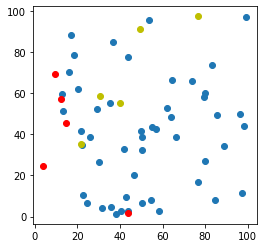

In [14]:
"""
赤がホテル、黄色が避難所
"""
plt.figure(figsize=(4, 4))
plt.plot(x_y[:, 0], x_y[:, 1], 'o')
plt.plot(locations[0:N_h,0],locations[0:N_h,1],"ro")
plt.plot(locations[N_h:,0],locations[N_h:,1],"yo")
#plt.plot((110,0),(0,110))
plt.show()

In [15]:
x = x_y[:, 0]
y = x_y[:, 1]
loc_x = locations[:, 0]
loc_y = locations[:, 1]
#loch_x = locations_h[:, 0]
#loch_y = locations_h[:, 1]

In [16]:
#避難所と住民の距離
di = np.sqrt((x[:, np.newaxis] - loc_x[np.newaxis, :]) ** 2 +(y[:, np.newaxis] - loc_y[np.newaxis, :]) ** 2 )
di = di.astype(np.int64)
a = np.zeros((N,1),dtype=np.int64)
di = np.concatenate([a,di],axis=1)

## gurobiで最適化

In [17]:
model = Model()

Using license file /Users/suzukinatsuki/gurobi.lic
Academic license - for non-commercial use only


In [18]:
#場所ごとに危険率を設定
H = np.zeros((N,N_sh+1),dtype=np.int64)
for i in people:
    H[i][0] = np.random.randint(10,20)
H

array([[17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [18,  0,  0,  0,  0,  0,  0,  0,  0,  0

In [19]:
#D[k,l]
D = np.zeros((N_sh+1,N_sh+1),dtype=np.int64)
for i in shelters:
    for j in shelters:
        if i == j and i != 0 and j!= 0:
            D[i,j] = 1
        else:
            D[i,j] = 0
D

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [20]:
#W[i,j]
W = np.zeros((N,N),dtype=np.int64)
for i in people:
    for j in people:
        w1 = max(infec_rate[j] - infec_rate[i],0) * mort_rate[i] + max(infec_rate[i] - infec_rate[j],0) * mort_rate[j]
        w2 = abs(infec_rate[j] - infec_rate[i])
        W[i,j] = w1*w2/10
W

array([[  0,   0, 327, ...,  81, 327,   9],
       [  0,   0, 338, ...,  84, 338,   9],
       [327, 338,   0, ...,   0,   0,  25],
       ...,
       [ 81,  84,   0, ...,   0,   0,   4],
       [327, 338,   0, ...,   0,   0,  25],
       [  9,   9,  25, ...,   4,  25,   0]])

In [21]:
#人iが避難施設kに避難した場合に1になる0-1変数 x[i,k] x[j,l]
x = {}
for i in people:
    for k in shelters:
        x[i,k] = model.addVar(ub=1, vtype="B", name="x(%s,%s)"%(i,k))
        
#for j in people:
#    for l in shelters:
#        x[j,l] = model.addVar(ub=1, vtype="B", name="x(%s,%s)"%(j,l))
        
model.update()

In [22]:
# z[i,k,j,l]という新しい変数をおく
z = {}
for i in people:
    for k in shelters:
        for j in people:
            for l in shelters:
                if j != i: 
                    z[i,k,j,l] = model.addVar(vtype="B",name="z(%s,%s,%s,%s)"%(i,k,j,l))
model.update()

In [23]:
# すべての人 iに対して，x[i,k]の施設kに対する合計 = 1   
for i in people:
    model.addConstr(quicksum(x[i,k] for k in shelters)== 1)
    
#すべての施設kに対して，x[i,k] の人に対する合計が施設kの容量以下
for k in shelters:
    model.addConstr(quicksum(x[i,k] for i in people) <= capacity[k])
model.update()

# Z[i,k,j,l]の制約
for i in people:
    for k in shelters:
        for j in people:
            for l in shelters:
                if j != i:
                    model.addConstr(z[i,k,j,l] >= x[i,k] + x[j,l] -1)
model.update()

In [25]:
#目的関数
model.setObjective(quicksum(W[i,j]*D[k,l]*z[i,k,j,l] + H[i,k]*x[i,k]
                            for i in people
                            for j in people
                            for k in shelters
                            for l in shelters
                            if j!=i), GRB.MINIMIZE)

model.update()

In [26]:
import time
start = time.time()
model.params.DualReductions = 0
model.params.LazyConstraints = 1
model.optimize()
model.Params.Timelimit = 3600
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print("--------------")

print ("Optimal solution:",model.ObjVal)

Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 296511 rows, 297000 columns and 890450 nonzeros
Model fingerprint: 0x3546a1a3
Variable types: 0 continuous, 297000 integer (297000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 1104836.0000
Presolve removed 12251 rows and 0 columns
Presolve time: 2.68s
Presolved: 284260 rows, 297000 columns, 853650 nonzeros
Variable types: 0 continuous, 297000 integer (297000 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    1961    8.5805064e+04   1.781464e+00   1.

In [27]:
#変数の確認
for v in model.getVars():
    if v.X> 0 and v.VarName[0] == 'x':
        print(v.VarName, v.X)
        xx = v.VarName

x(0,8) 1.0
x(1,8) 1.0
x(2,0) 1.0
x(3,0) 1.0
x(4,9) 1.0
x(5,6) 1.0
x(6,6) 1.0
x(7,4) 1.0
x(8,6) 1.0
x(9,6) 1.0
x(10,6) 1.0
x(11,0) 1.0
x(12,0) 1.0
x(13,3) 1.0
x(14,1) 1.0
x(15,2) 1.0
x(16,10) 1.0
x(17,7) 1.0
x(18,10) 1.0
x(19,6) 1.0
x(20,9) 1.0
x(21,9) 1.0
x(22,0) 1.0
x(23,9) 1.0
x(24,9) 1.0
x(25,8) 1.0
x(26,10) 1.0
x(27,7) 1.0
x(28,5) 1.0
x(29,0) 1.0
x(30,0) 1.0
x(31,0) 1.0
x(32,0) 1.0
x(33,8) 1.0
x(34,7) 1.0
x(35,9) 1.0
x(36,0) 1.0
x(37,9) 1.0
x(38,0) 1.0
x(39,0) 1.0
x(40,10) 1.0
x(41,9) 1.0
x(42,8) 1.0
x(43,7) 1.0
x(44,8) 1.0
x(45,7) 1.0
x(46,0) 1.0
x(47,6) 1.0
x(48,0) 1.0
x(49,10) 1.0


In [28]:
import re
L = [i for i in shelters]
count = {}
L2 = []
for i in L:
    count[i] = 0
pattern = "(.*),(\d+)"
for v in model.getVars():
    if v.X> 0 and v.VarName[0] == 'x':
        regdate = v.VarName
        d = re.search(pattern, regdate)
        count[int(d.group(2))] += 1

[14, 1, 1, 1, 1, 1, 7, 5, 6, 8, 5]


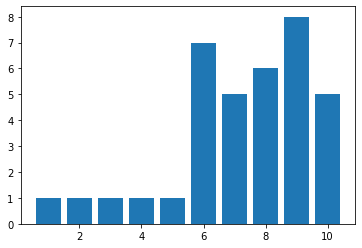

In [29]:
for j in count:
    L2.append(count[j])
import numpy as np
import matplotlib.pyplot as plt
left = L[1:]
height = L2[1:]
plt.bar(left, height)
print(L2)